# GPT with Medusa for multi-token prediction

In [ ]:
# Notebook created from following video:       https://youtu.be/0_fZNW59PaA?si=6WSJMRdT2vZSFJGY  
# And associated repo:                         https://github.com/evintunador/medusas_uglier_sisters  
# Based on paper:                              https://arxiv.org/abs/2401.10774  
# And based on GPT implementation by Kaparthy: https://youtu.be/kCc8FmEb1nY?si=d4rto2AxG7pCs9hn  

Medusa is a framework for enabling any GPT model to conduct multi-token prediction, instead of next-token prediction. It works by adding additional final linear heads to the model, and adjusting the loss function, such that each N head is prediction the token N steps ahead of the input. Only these additional heads need to be trained so this framework can be applied to existing, trained models. The paper also suggests a tree-based attention mechanism, which isn't implemented in the below code, because the dataset being used doesn't require a complex attenntion mechanism.

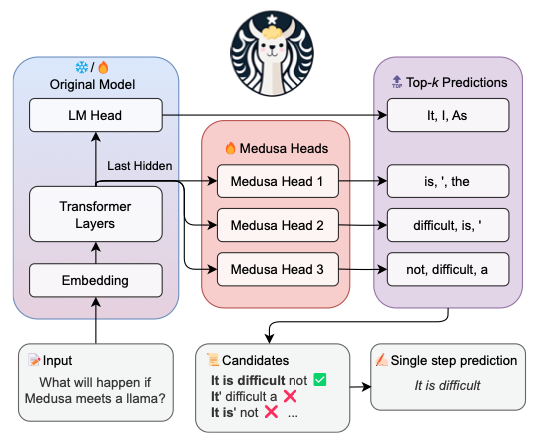

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time

## Normal GPT Setup  
### Load dataset, create encoding and decoding method, setup batches

In [2]:
# Download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-01-31 23:54:36--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-01-31 23:54:36 (20.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

In [6]:
# create a mapping from characters to integers
stoi   = { ch:i for i,ch in enumerate(chars) }
itos   = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]          # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hello world"))
print(decode(encode("hello world")))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)

In [8]:
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# split into train and validation datasets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data   = data[n:]

In [10]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input tokens are {context}, which is {decode(context.tolist())}, then the target is {target}, which is {decode([target.tolist()])}")

when input tokens are tensor([18]), which is F, then the target is 47, which is i
when input tokens are tensor([18, 47]), which is Fi, then the target is 56, which is r
when input tokens are tensor([18, 47, 56]), which is Fir, then the target is 57, which is s
when input tokens are tensor([18, 47, 56, 57]), which is Firs, then the target is 58, which is t
when input tokens are tensor([18, 47, 56, 57, 58]), which is First, then the target is 1, which is  
when input tokens are tensor([18, 47, 56, 57, 58,  1]), which is First , then the target is 15, which is C
when input tokens are tensor([18, 47, 56, 57, 58,  1, 15]), which is First C, then the target is 47, which is i
when input tokens are tensor([18, 47, 56, 57, 58,  1, 15, 47]), which is First Ci, then the target is 58, which is t


In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    print("--- Batch ",b," ---")
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input tokens are {context}, which is {decode(context.tolist())}, then the target is {target}, which is {decode([target.tolist()])}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
--- Batch  0  ---
when input tokens are tensor([24]), which is L, then the target is 43, which is e
when input tokens are tensor([24, 43]), which is Le, then the target is 58, which is t
when input tokens are tensor([24, 43, 58]), which is Let, then the target is 5, which is '
when input tokens are tensor([24, 43, 58,  5]), which is Let', then the target is 57, which is s
when input tokens are tensor([24, 43, 58,  5, 57]), which is Let's, then the target is 1, which is  
when input tokens are tensor([24, 43, 58,  5, 57,  1]), which is Let's , then the target is 46, which is h
when input tokens a

## Medusa

In [13]:
# hyperparameters
batch_size = 36#24 #16 # how many independent sequences will we process in parallel?
block_size = 64 #32 # what is the maximum context length for predictions?
max_iters = 10000 #8000#5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64#128 #64
n_head = 8 #4
n_layer = 8 #4
dropout = 0.2 #0.0

# C: medusa hyperparameters
m = 4 # number of medusa heads
# we use the discount to make heads further in the future take up less of the gradient
# this also means that the later heads are significantly less accurate
# C: entirely removed discount; was bad.
medusa_discount = torch.tensor(0.5).to(device) # 0.8
torch.manual_seed(1337)

In [14]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    indexes = torch.randint(len(data) - block_size - m, (batch_size,)) # generate these random indexes in range
    x = torch.stack([data[i : i+block_size] for i in indexes]) # get the data for those random indexes
    # y = torch.stack([data[i+1 : i+block_size+1] for i in ix]) # get the data for those random indexes

    # in a regular next-token prediction GPT you'd want y to be the same size as x
    # and only contain the next timestep. Here we want 1 + m timesteps so that we
    # can train each medusa head
    y = torch.stack([torch.stack([data[i+1+j : i+block_size+1+j] for i in indexes]) for j in range(m+1)])
    x, y = x.to(device), y.to(device)
    return x, y

In [15]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # put in evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split) # get some random data from the dataset
            logits, loss, medusa_logits = model(X, Y) # pass through model, get back "unnormalised probabilities" / predictions, loss
            losses[k] = loss.item() # save loss from each
        out[split] = losses.mean() # save the mean loss
    model.train() # put back in training mode
    return out

In [16]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [17]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [18]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [19]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [20]:
class snake(nn.Module):
    """
    A single Medusa head
    Notice how the transformer's regular output head uses just a single (d,v) matrix
      whereas here we do a (d,d) linear, the activation, then a (d,v) linear. If I
      cared about being efficient or sensical I probably would've made the regular
      transformer head act like this too, but
          1) I like the separation of base head from medusa heads for teaching purposes
          2) in the medusa paper they create medusa heads after a regular head with the
             single (d,v) matrix has already been trained, so this is what theirs looks
             like
    """
    def __init__(self):
        super().__init__()
        self.w1 = nn.Linear(n_embd,n_embd) # C: d,d which is n_embd, n_embd
        self.relu = nn.ReLU() # actual paper uses SiLU bc they build off Llama
        self.w2 = nn.Linear(n_embd,vocab_size) # C: d, v which is n_embd, vocab_size

        # i wasn't sure where to put the dropout tbh
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(self.relu(self.w1(x))+x)) # outputs logits shape (b,t,v)

In [21]:
# super simple bigram model - now with Medusa :)
class MedusaGPT(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # Create a list of Medusa heads
        self.medusa_heads = nn.ModuleList([snake() for _ in range(m)])

        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None, medusa_targets=None, verbose=False):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C) # add the token embedding and position embedding together

        x = self.blocks(x) # (B,T,C) # pass this through the blocks - a sequence of transformer blocks
        # reminder, transformer blocks: layer norm, multihead attention, layer norm, feed forward
        # where, multihead attention: linear and then dropout,
        # and, feed forward: linear, relu, linear, dropout
        x = self.ln_f(x) # (B,T,C) # pass the above output through a layer norm

        # the regular next-token prediction head
        logits = self.lm_head(x) # (B,T,vocab_size) # get the unnomalised probabilities # this is another linear layer of n_embd by vocab_size

        # Apply each snake head to x and store the results
        medusa_logits = torch.stack([head(x) for head in self.medusa_heads], dim=0)


        if verbose:
            print("final residual: ", x.shape, x)
            print("logits: ", logits.shape, logits)
            print("medusa_logits: ", medusa_logits.shape, medusa_logits)

        if targets is None:
            # if we're not training we can ignore loss
            loss = None
            medusa_loss = None
        else:
            m, b, t, v = medusa_logits.shape
            logits = logits.view(b*t, v)
            targets0 = targets[0].view(b*t)
            loss = F.cross_entropy(logits, targets0) # calculate the loss between logits and targets # this is, the difference between the probabilities/predictions and actual values

            # creating the loss for the medusa heads
            mloss = []
            for i in range(m):
                # notice the medusa discount being raised to the power of i+1
                mloss.append(F.cross_entropy(medusa_logits[i].view(b*t,v), targets[i+1].view(b*t)))#*medusa_discount**(i+1))
            medusa_loss = torch.stack(mloss)

            loss = loss + medusa_loss.sum()

        return logits, loss, medusa_logits # return the unnormalised probabilities, loss and medusa_logits


    # def generate_gpt(self, idx, max_new_tokens, temperature=1.0): # (1,1) and 100 tokens
    #     # idx is (B, T) array of indices in the current context
    #     for _ in range(max_new_tokens): # generate 1 token each loop, so loop 100 times
    #         # crop idx to the last block_size tokens
    #         idx_cond = idx[:, -block_size:] # block size == context window
    #         # get the predictions
    #         logits, loss, mlogits = self(idx_cond) # forward()
    #         # focus only on the last time step
    #         logits = logits[:, -1, :] # becomes (B, C) # get the final unnormalised probability (token)
    #         # scale logits by the temperature
    #         logits = logits / (temperature+1e-10)
    #         # apply softmax to get probabilities
    #         probs = F.softmax(logits, dim=-1) # (B, C) # unnormalised prob -> prediction
    #         # sample from the distribution
    #         idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) # get prediction from distribution
    #         # append sampled index to the running sequence
    #         idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) # add to result being built
    #     return idx


    def generate_Stheno(model, idx, max_runs, verbose=False):
      # Ensure idx is a single sequence. This won't work for batched inference
      assert idx.size(0) == 1, "idx must be of size (1, t)"
      if verbose: print("idx: ", idx.shape)

      # crop idx to the last block_size tokens jic it's too long
      input_cond = idx[:, -block_size:]
      if verbose: print("idx_cond should be size (1, t): ", input_cond.shape)

      # get the predictions
      logits, loss, mlogits = model(input_cond) # (1,t,v), int, and (m,1,t,v)
      if verbose: print("logits should be (1,t,v): ", logits.shape)
      if verbose: print("mlogits should be (m,1,t,v): ", mlogits.shape)

      # we only want the medusa preditions for the newest future timestep
      mlogits = mlogits[...,-1,:] # becomes (m,1,v)
      mlogits = mlogits.squeeze(dim=1) # (m,v)
      if verbose: print("mlogits should be (m,v): ", mlogits.shape)

      # actual medusa does a whole proabability attention mask tree thing,
      #   but here we'll assume greedy decoding on snake heads
      idx_m_prev = torch.argmax(mlogits, dim=-1, keepdim=True).t() # (1,m)
      if verbose: print("idx_m_prev should be (1,m): ", idx_m_prev.shape)
      # we name it _prev since it'll be used on the next loop

      # medusa requires greedy decoding for the first regular t+1'th token
      idx_ntp = torch.argmax(logits, dim=-1, keepdim=True).squeeze(dim=2) # (1, t)
      if verbose: print("idx_ntp should be (1, t): ", idx_ntp.shape)

      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_ntp[:,-1].unsqueeze(dim=0)), dim=1) # (1,t)+(1,1) -> (1, t+1)
      if verbose: print("idx should be (1, t+1): ", idx.shape)

      # keep track of how many tokens we get per model inference
      tok_per_inf = [1]

      for _ in range(max_runs-1): # -1 since one iteration was done above
          ###### I think this is where i begin the looped part. above stuff should be before the for loop

          # so now we have idx shape (1,t+1) of context tokens plus 1 predicted token
          # and idx_m_prev shape  (1,m) of speculative tokens to check against later & include some
          # want to know whether model actually would've predicted the tokens in idx_m so we need to run it with them & compare

          # first we construct a tensor composed of the initial context, the single ntp token, and then the speculative tokens
          inp = torch.cat((idx, idx_m_prev), dim=1) # (1,t+1) & (1,m) -> (1,t+1+m)
          if verbose: print("input should be (1,t+1+m): ", inp.shape)

          # but since the model can't take more than t inputs
          # note: t is max content limit, but input might be shorter. if so that's fine
          input_cond = inp[:, -block_size:]
          # (1,t+1+m) -> (1,t) where first t-1-m are prior context, the t-m'th is ntp, & last m are candidates
          if verbose: print("input_cond should be (1,t): ", input_cond.shape)

          # then we pass it in
          logits, loss, mlogits = model(input_cond) # (1,t,v), tensor of a single float, & (m,1,t,v)

          # we're just greedy decoding so there's no need to softmax
          idx_ntp = torch.argmax(logits, dim=-1, keepdim=True).squeeze(dim=2) # (1,t,v) -> (1, t)
          if verbose: print("idx_ntp should be (1, t): ", idx_ntp.shape)

          # now for making the comparison we need to ignore the indices that were part of the context
          # the regular ntp prediction can also be ignored
          # we just need to know the number of previous turn's medusa preds to keep
          idx_check = idx_ntp[:,-(m+1):-1] # (1,t) -> (1,m)
          if verbose: print("idx_check should be (1,m): ", idx_check.shape, "\n", idx_check)

          # let's start checking whether they match
          match_tensor = (idx_m_prev == idx_check).int()
          #(1,m) of ints & (1,m) of ints -> (1,m) of 1's and 0's
          if verbose: print("match_tensor should be (1,m) of 1's and 0's: ", match_tensor.shape, "\n", match_tensor)

          # then define our "definitely good" indices as those which are 1's for the similarity check
          # We invert the tensor so that all zeros & 1's flip
          # Find the first 1 in each row. The max function returns the index of the first occurrence of the maximum value.
          # We add one extra zero at the end of each row to handle rows that contain no zeros.
          pad = torch.ones(match_tensor.size(0), 1, dtype=match_tensor.dtype, device=device)
          if verbose: print("pad: ", pad.shape, "\n", pad)
          padded_tensor = torch.cat((1 - match_tensor, pad), dim=1)
          if verbose: print("padded_tensor: ", padded_tensor.shape, "\n", padded_tensor)
          zero_positions = padded_tensor.argmax(dim=1)

          # Adjust indices where the last position is selected (meaning there were no zeros)
          zero_positions[zero_positions >= match_tensor.size(1)] = match_tensor.size(1)
          if verbose: print("zero_positions: ", zero_positions.shape, "\n", zero_positions)

          # Create a range tensor
          range_tensor = torch.arange(match_tensor.size(1), device=device).unsqueeze(0).expand_as(match_tensor)
          if verbose: print("range_tensor: ", range_tensor.shape, "\n", range_tensor)

          # Create a mask where each element is 1 if it is before the first zero in its row
          mask = range_tensor < zero_positions.unsqueeze(1)
          if verbose: print("mask: ", mask.shape, "\n", mask)

          # Apply the mask and sum along each row
          result = (match_tensor * mask).sum(dim=1).item()
          if verbose: print("result: ", result)

          tok_per_inf.append(result+1)

          # so now i've got result which is an integer between 0 and m (inclusive)
          # i need to use it as an index on the actual medusa head outputs of interest and then append that to our sequence
          # but we also get to use the regular ntp prediction right after any of last run's accepted medusa head predictions
          if verbose: print("idx: ", idx.shape, "\n", idx)
          idx_m_prev = idx_m_prev[:,:result]
          if verbose: print("idx_m_prev should be (1,result): ", idx_m_prev.shape, "\n", idx_m_prev)
          idx_ntp = idx_ntp[:,-1-m+result].unsqueeze(dim=0)
          if verbose: print("idx_ntp should be (1,1): ", idx_ntp.shape, "\n", idx_ntp)
          idx = torch.cat((idx, idx_m_prev, idx_ntp),dim=1)
          if verbose: print("idx should be (1,t+result+1: ", idx.shape, "\n", idx)

          # so now we have idx of size (1,t+1+result)
          # and idx_m of size (1,m)
          # wait but there's a problem. If we didn't use the largest result=m then
          #   idx_m is for items too far into the future. we need to pass forward an idx_m that's relevant
          # ngl i'm too tired to think about it so i'm assuming i can use the same index i used for idx_ntp
          mlogits = mlogits[...,-1-m+result,:].squeeze(dim=1) # (m,1,t,v) -> (m,1,v)
          if verbose: print("mlogits: ", mlogits.shape)
          idx_m_prev = torch.argmax(mlogits, dim=-1, keepdim=True).t() # (m,1,v) -> (1,m)
          if verbose: print("idx_m_prev: ", idx_m_prev.shape, "\n", idx_m_prev)
          # we name it _prev since it'll be used on the next loop

      return idx, tok_per_inf, (idx, idx_m_prev)

## Train GPT with Medusa heads

In [22]:
model = MedusaGPT()
mod = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in mod.parameters())/1e6, 'M parameters')

0.444485 M parameters


In [23]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

start_time = time.time()
for iter in range(max_iters):

    # # every once in a while evaluate the loss on train and val sets
    # if iter % eval_interval == 0 or iter == max_iters - 1:
    #     losses = estimate_loss()
    #     print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train') # get random data from training data

    # evaluate the loss
    logits, loss, mlogits = model(xb, yb) # pass data through model and get back unnormalised probabilties, and loss
    # model() is equivalent to model.__call__() which, since the model is nn.Module,
    # according to Pytorch, calls .forward()
    # (https://www.geeksforgeeks.org/__call__-in-python/) and (https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # loss is cross entropy
    # uses the chain rule to calculate loss "with respect to each tensor in the graph"
    # it relates to updating the parameters... to understand better....
    optimizer.step()

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

step 0: train loss 20.4266, val loss 20.4368, time elapsed: 1.01 seconds
step 100: train loss 15.4767, val loss 15.5193, time elapsed: 26.70 seconds
step 200: train loss 14.9461, val loss 15.0079, time elapsed: 50.39 seconds
step 300: train loss 14.7016, val loss 14.7210, time elapsed: 69.83 seconds
step 400: train loss 14.5219, val loss 14.5952, time elapsed: 89.52 seconds
step 500: train loss 14.4217, val loss 14.5346, time elapsed: 109.77 seconds
step 600: train loss 14.2358, val loss 14.3005, time elapsed: 128.92 seconds
step 700: train loss 14.1179, val loss 14.1681, time elapsed: 148.81 seconds
step 800: train loss 14.0127, val loss 14.1486, time elapsed: 168.62 seconds
step 900: train loss 13.9086, val loss 14.0131, time elapsed: 187.95 seconds
step 1000: train loss 13.7857, val loss 13.9637, time elapsed: 208.52 seconds
step 1100: train loss 13.7024, val loss 13.8863, time elapsed: 227.80 seconds
step 1200: train loss 13.6100, val loss 13.8350, time elapsed: 247.49 seconds
step

## Inference

In [24]:
def generate_from_model(input_str, length):
  context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)
  output, tok_per_inf, x = mod.generate_Stheno(context_tensor, max_runs=length)
  output_str = decode(output[0].tolist())
  print("tokens per inference: ", sum(tok_per_inf)/len(tok_per_inf))
  print(output_str)

In [28]:
input_str = "HAMLET:\nTo b"
generate_from_model(input_str, 100)

tokens per inference:  1.89
HAMLET:
To be the good of the proves of the sorrow,
And the shall of the presect of the man
To the state of the sone of the stander to thee.

LADY ANNE:
The will be the made the sould be the stranded t


In [29]:
input_str = "JULIET:\nO Romeo,"
generate_from_model(input_str, 100)

tokens per inference:  1.87
JULIET:
O Romeo, the shall and the string of the seat.

CLIFFORD:
Ay, and then the shall be the sounder and
The stand of the sent to the son of the sour,
And the prove of the shall the stand to thee.

CA


In [31]:
input_str = "MACBETH:\n"
generate_from_model(input_str, 100)

tokens per inference:  1.68
MACBETH:
And the soul of the souls of the shappers
To the sent of the prove the honour of thee,
And the stay of the send of the dear of the state,
And the son of the so death th
